<a href="https://colab.research.google.com/github/Hrk0612/Torque-Level-Classification-in-Bolted-Joints/blob/main/ORION_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bolt Loosening Detection and  Classification using Machine Learning on the ORION-AE Dataset**

# **Project Setup**

First, set up the Google Colab environment and understand the dataset. We begin by importing essential libraries for data processing, signal analysis, visualization, and model building. This includes NumPy, Pandas, SciPy for signal handling, scikit-learn and XGBoost for machine learning, PyWavelets for time-frequency feature extraction, and plotting libraries like Matplotlib and Seaborn. Initial visual settings and warnings are configured to streamline the workflow.

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.io import loadmat
from scipy.stats import kurtosis, skew
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import pywt
import os
import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)
print("Environment setup complete.")

Environment setup complete.


**Understanding the Dataset**

* The dataset contains raw AE data streams from 3 different AE sensors and a laser vibrometer

* 5 measurement campaigns (B, C, D, E, F)

* 7 tightening levels (60, 50, 40, 30, 20, 10, 5 cNm)

* Sampling rate is 5 MHz (5 million samples per second)

* Each .mat file contains about 1 second of data (5 million samples per sensor)

* Variables in each file:

1.   A: micro80 sensor
2.   B: F50A sensor
3.   C: micro200HF sensor
4.   D: laser vibrometer

# **Data Loading**

This section loads acoustic emission data from the ORION-AE dataset for a specified bolt tightening level. The function navigates the directory structure, reads .mat files, and extracts sensor-specific signals. It allows control over the number of files loaded and supports data inspection. In this case, we load sensor A data from Campaign B at the 60cNm tightening level.

In [ ]:
def load_orion_ae_data(data_path, campaign='B', tightening_level='60cNm', sensor='A', max_files=None, plot_example=True):
    campaign_dir = os.path.join(data_path, f'Campaign_{campaign}')
    level_dir = os.path.join(campaign_dir, tightening_level)
    if not os.path.exists(level_dir):
        raise ValueError(f"Directory {level_dir} does not exist")

    mat_files = [f for f in os.listdir(level_dir) if f.endswith('.mat')]
    mat_files.sort()
    if max_files:
        mat_files = mat_files[:max_files]

    data = []
    for idx, mat_file in enumerate(mat_files):
        file_path = os.path.join(level_dir, mat_file)
        mat_data = loadmat(file_path)

        if sensor not in mat_data or 'D' not in mat_data:
            print(f"Missing expected keys in {mat_file}")
            continue
        sensor_data = mat_data[sensor].flatten()
        vibro_data = mat_data['D'].flatten()
        data.append(sensor_data)

    print(f"Loaded {len(data)} files for {tightening_level}")
    return data

data_path = "/content/drive/MyDrive/dataverse"
sample_data = load_orion_ae_data(data_path, campaign='B', tightening_level='60cNm', sensor='A', max_files=None)

Loaded 10 files for 60cNm


**Signal Preview**

After loading the data, we verify the number of files and inspect the shape of the first signal. A portion of the acoustic emission (AE) signal from the first file is plotted to visualize its time-domain behavior. This helps confirm successful data loading and provides insight into the raw waveform characteristics.

Files loaded: 10
First signal shape: (4325376,)


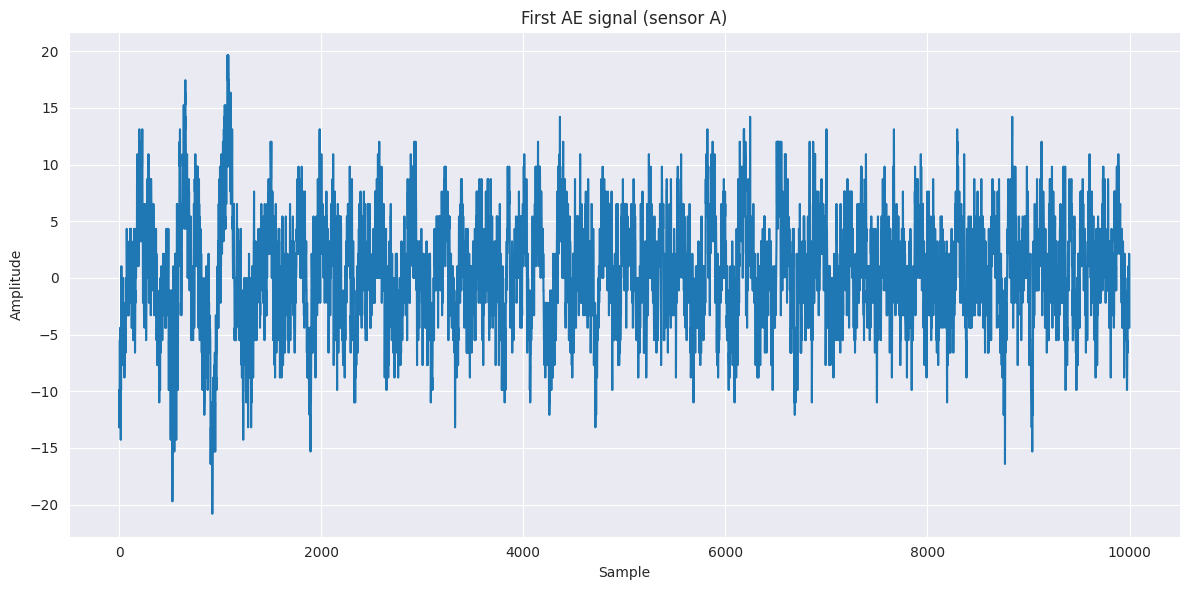

In [ ]:
print("Files loaded:", len(sample_data))
print("First signal shape:", sample_data[0].shape)

# Plot part of the signal
plt.plot(sample_data[0][:10000])
plt.title("First AE signal (sensor A)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


**Multi-Level AE & Vibrometer Signal Visualization**

This section visualizes both Acoustic Emission (AE) and vibrometer signals across multiple bolt tightening levels (05cNm to 60cNm). For each level, the first .mat file is loaded, and a short time window (0.05s) is plotted to compare AE and vibration signals side by side. This helps in observing how signal characteristics evolve with tightening torque.



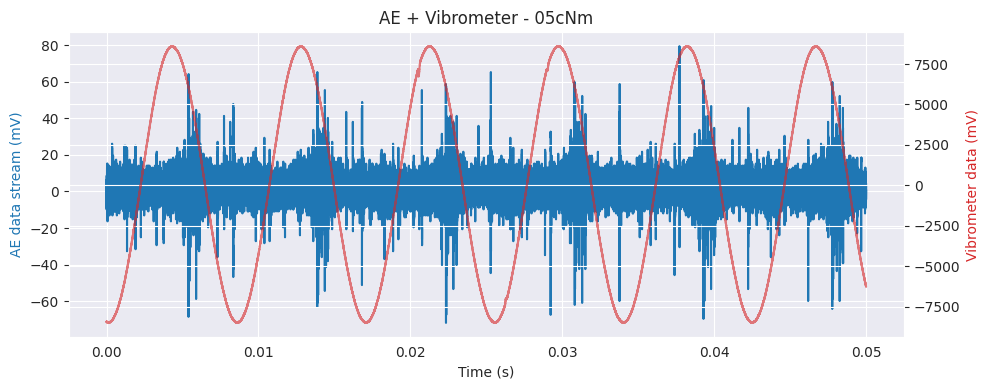

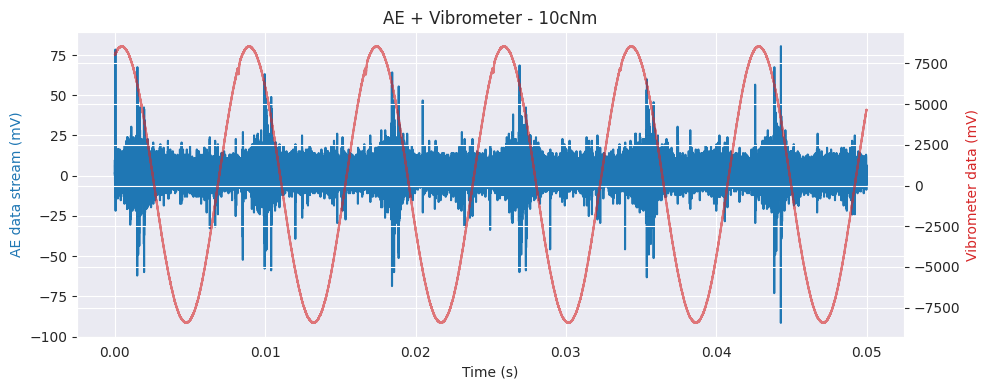

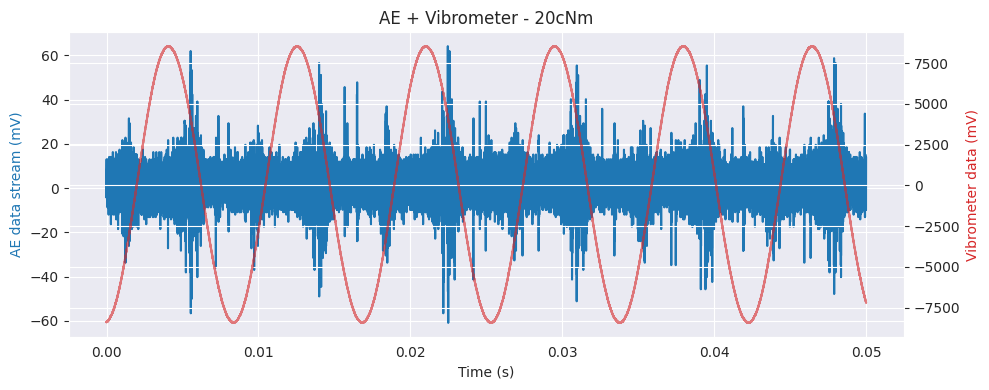

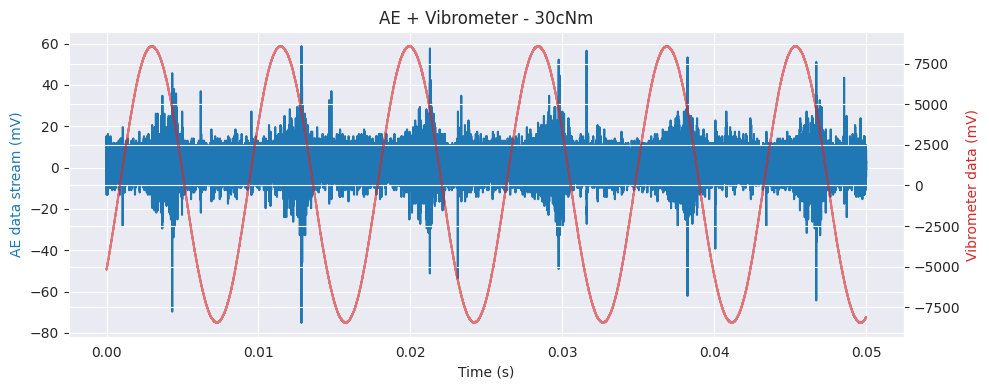

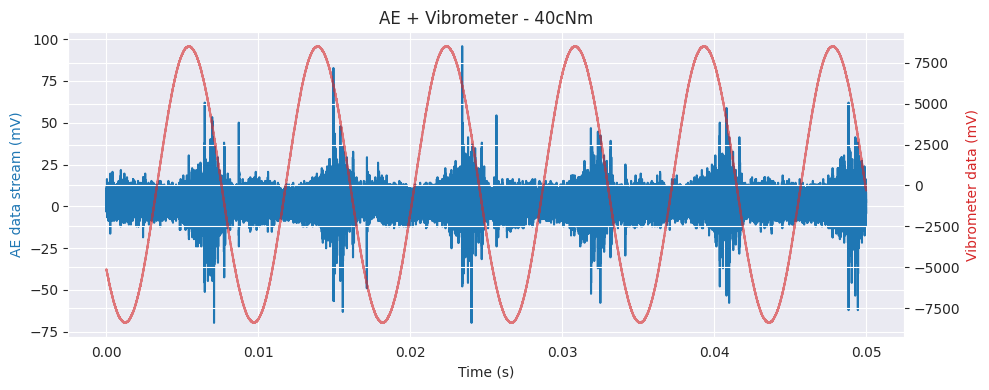

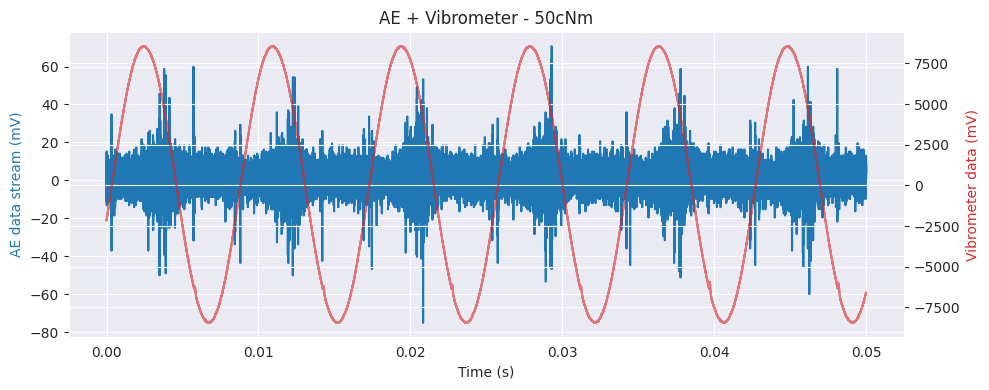

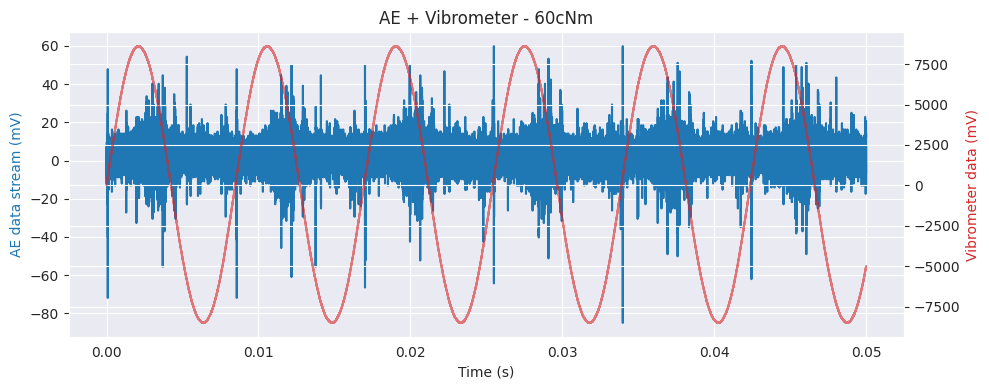

In [ ]:
def plot_ae_vibrometer_all_levels(data_path, campaign='B', levels=None, sensor='B'):
    if levels is None:
        levels = ['05cNm', '10cNm', '20cNm', '30cNm', '40cNm', '50cNm', '60cNm']
    for level in levels:
        try:
            campaign_dir = os.path.join(data_path, f'Campaign_{campaign}')
            level_dir = os.path.join(campaign_dir, level)
            files = sorted([f for f in os.listdir(level_dir) if f.endswith('.mat')])
            file_path = os.path.join(level_dir, files[0])
            mat_data = loadmat(file_path)
            ae = mat_data[sensor].flatten()
            vibro = mat_data['D'].flatten()
            time = np.arange(len(ae)) / 5e6

            # Zoom in on 0.045s window
            start_idx = 0
            end_idx = int(0.05 * 5e6)
            time = time[start_idx:end_idx]
            ae = ae[start_idx:end_idx]
            vibro = vibro[start_idx:end_idx]

            fig, ax1 = plt.subplots(figsize=(10, 4))
            ax1.plot(time, ae, color='tab:blue')
            ax1.set_xlabel("Time (s)")
            ax1.set_ylabel("AE data stream (mV)", color='tab:blue')
            ax2 = ax1.twinx()
            ax2.plot(time, vibro, color='tab:red', alpha=0.6)
            ax2.set_ylabel("Vibrometer data (mV)", color='tab:red')
            plt.title(f"AE + Vibrometer - {level}")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Skipping {level}: {e}")

plot_ae_vibrometer_all_levels("/content/drive/MyDrive/dataverse", campaign='B', sensor='B')

# **Data Preprocessing**

This section applies signal denoising and filtering techniques to enhance signal quality for feature extraction. A wavelet-based denoising approach (db8, level 14) is used to suppress noise, followed by a bandpass filter (50–400 kHz) to isolate relevant frequency components. The resulting signals are then normalized and segmented into overlapping windows to prepare for downstream analysis.

In [ ]:
def wavelet_denoise(signal_data, wavelet='db8', level=14, thresholding='soft'):
    # Wavelet decomposition
    coeffs = pywt.wavedec(signal_data, wavelet, level=level)

    # Thresholding (using universal threshold)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745  # Median absolute deviation
    threshold = sigma * np.sqrt(2 * np.log(len(signal_data)))

    # Applied threshold to detail coefficients
    coeffs_thresh = [coeffs[0]]
    for i in range(1, len(coeffs)):
        coeffs_thresh.append(pywt.threshold(coeffs[i], threshold, mode=thresholding))

    # Reconstruct the signal
    denoised = pywt.waverec(coeffs_thresh, wavelet)

    # Trim to original length in case of odd length
    return denoised[:len(signal_data)]

def preprocess_data(data_chunks, sampling_rate=5e6, window_size=2000, stride=3000):
    all_windows = []
    for chunk in data_chunks:
        denoised = wavelet_denoise(chunk)
        nyquist = 0.5 * sampling_rate
        low = 50e3 / nyquist
        high = 400e3 / nyquist
        b, a = signal.butter(5, [low, high], btype='band')
        filtered = signal.filtfilt(b, a, denoised)
        normalized = (filtered - np.mean(filtered)) / np.std(filtered)

        # Slice into windows
        for start in range(0, len(normalized) - window_size + 1, stride):
            window = normalized[start:start + window_size]
            all_windows.append(window)
    return all_windows
processed_data = preprocess_data(sample_data)
print(type(processed_data), len(processed_data))


<class 'list'> 16666


**Preprocessing Comparison Across Levels**

This section visualizes the impact of preprocessing (denoising, filtering, and normalization) on raw AE signals for each bolt tightening level. By overlaying raw and processed signals, we can clearly observe the noise reduction and signal enhancement, validating the effectiveness of the preprocessing pipeline.

Loaded 1 files for 05cNm


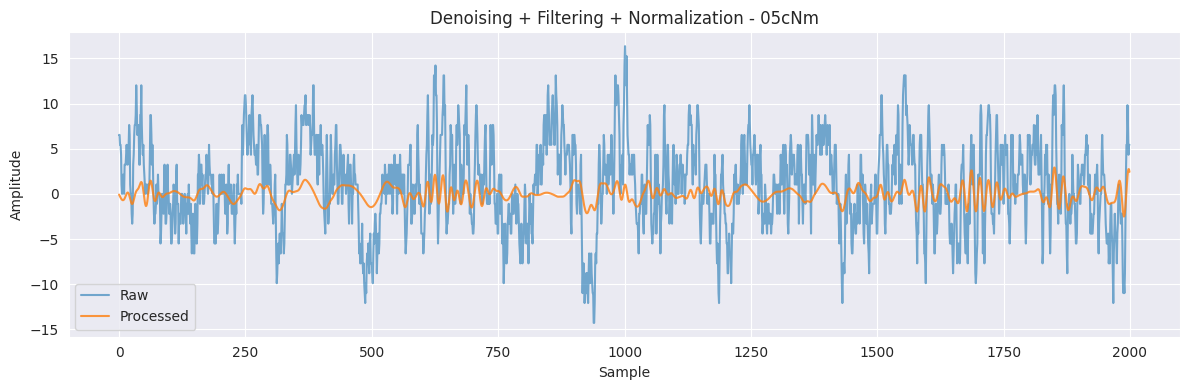

Loaded 1 files for 10cNm


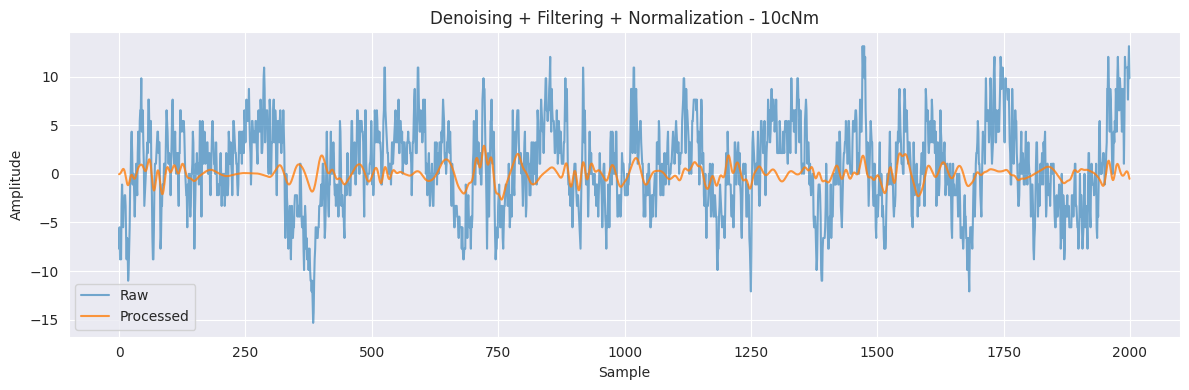

Loaded 1 files for 20cNm


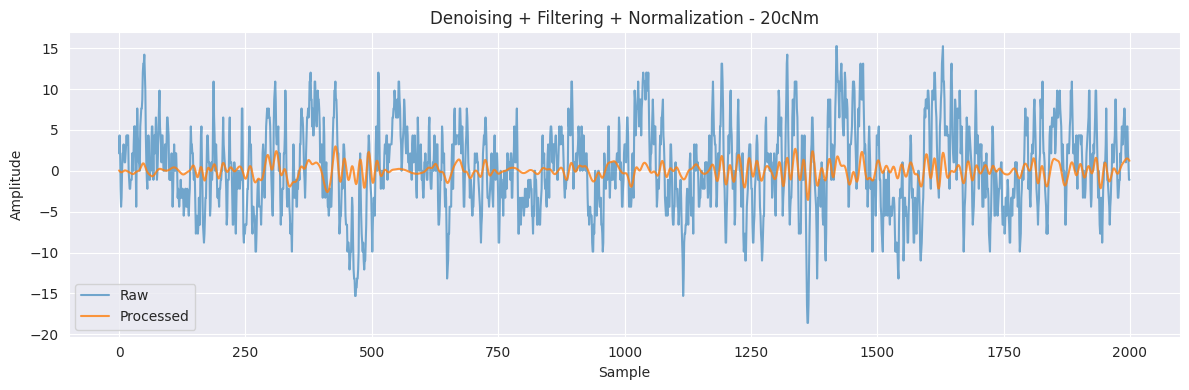

Loaded 1 files for 30cNm


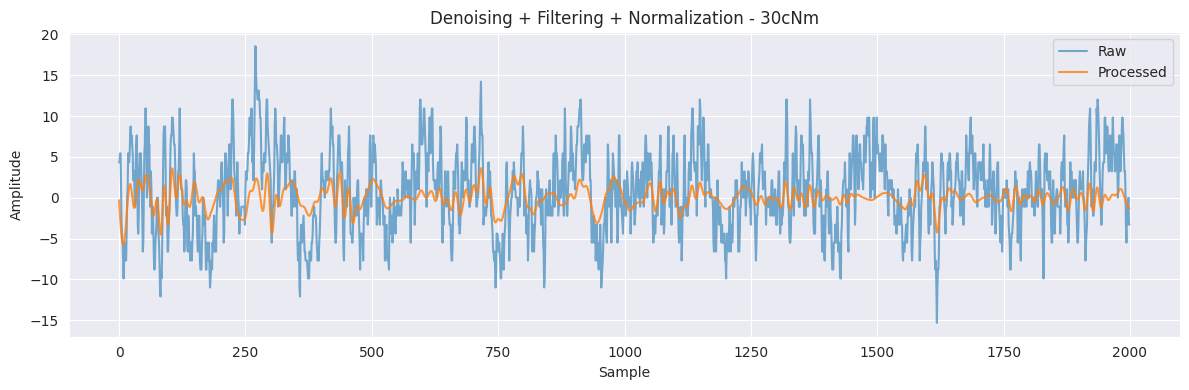

Loaded 1 files for 40cNm


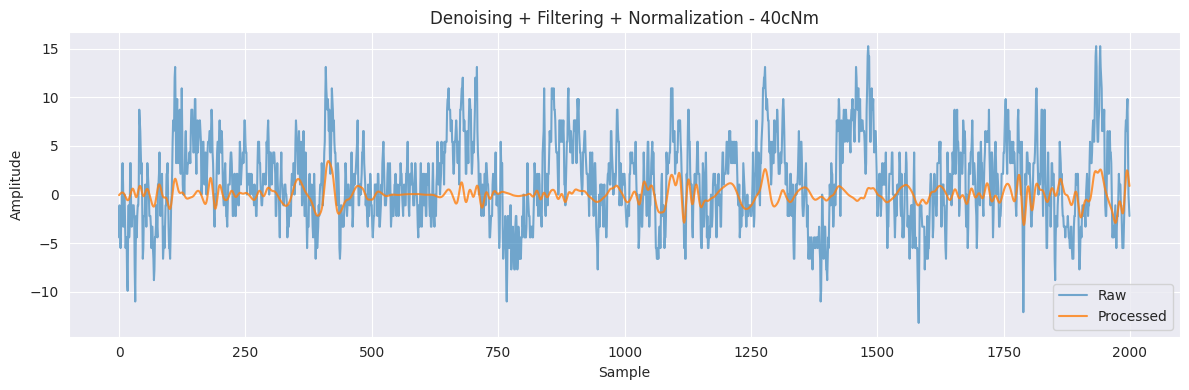

Loaded 1 files for 50cNm


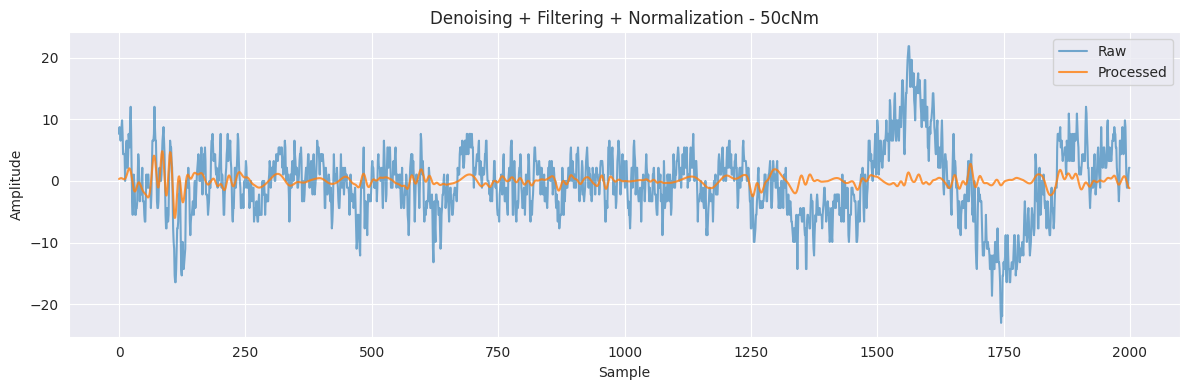

Loaded 1 files for 60cNm


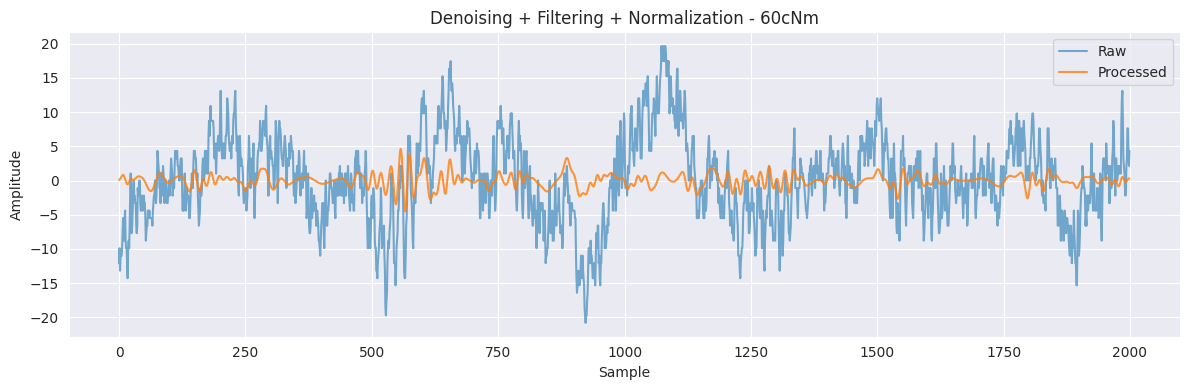

In [ ]:
def plot_preprocessing_comparison_all_levels(data_path, campaign='B', sensor='A', levels=None):
    if levels is None:
        levels = ['05cNm', '10cNm', '20cNm', '30cNm', '40cNm', '50cNm', '60cNm']

    for level in levels:
        raw_data = load_orion_ae_data(data_path, campaign=campaign, tightening_level=level, sensor=sensor, max_files=1)
        processed_data = preprocess_data(raw_data)

        plt.figure(figsize=(12, 4))
        plt.plot(raw_data[0][:2000], label='Raw', alpha=0.6)
        plt.plot(processed_data[0][:2000], label='Processed', alpha=0.8)
        plt.title(f"Denoising + Filtering + Normalization - {level}")
        plt.xlabel("Sample")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

data_path = "/content/drive/MyDrive/dataverse"
plot_preprocessing_comparison_all_levels(data_path, campaign='B', sensor='A')


# **Feature Extraction**

In this section, statistical and frequency-domain features are extracted from preprocessed AE signal windows. Each segment is characterized by metrics like mean, RMS, kurtosis, and spectral centroid. Additionally, energy is computed over three frequency bands (low, mid, high). These features are compiled into a labeled dataset spanning all torque levels (05cNm–60cNm), enabling supervised learning. The final dataset is optionally saved as a Feather file for fast storage and retrieval.

In [ ]:
def extract_features(signal_data, sampling_rate=5e6):
    features = {}
    features['mean'] = np.mean(signal_data)
    features['std'] = np.std(signal_data)
    features['rms'] = np.sqrt(np.mean(np.square(signal_data)))
    features['peak'] = np.max(np.abs(signal_data))
    features['kurtosis'] = kurtosis(signal_data)
    features['skewness'] = skew(signal_data)

    fft_vals = np.abs(np.fft.fft(signal_data))
    fft_freq = np.fft.fftfreq(len(signal_data), 1/sampling_rate)
    fft_vals = fft_vals[fft_freq >= 0]
    fft_freq = fft_freq[fft_freq >= 0]

    features['centroid'] = np.sum(fft_freq * fft_vals) / np.sum(fft_vals)
    features['peak_freq'] = fft_freq[np.argmax(fft_vals)]

    bands = {
        'low': (50e3, 150e3),
        'mid': (150e3, 275e3),
        'high': (275e3, 400e3)
    }
    for band_name, (low, high) in bands.items():
        mask = (fft_freq >= low) & (fft_freq <= high)
        features[f'energy_{band_name}'] = np.sum(fft_vals[mask]**2)
    return features


def create_feature_dataset(data_chunks, labels=None, sampling_rate=5e6, group_ids=None):
    features_list = []
    for i, chunk in enumerate(data_chunks):
        features = extract_features(chunk, sampling_rate)
        if labels is not None:
            features['label'] = labels[i]
        if group_ids is not None:
            features['group'] = group_ids[i]
        features_list.append(features)
    return pd.DataFrame(features_list)


def build_full_dataset(data_path, campaign='B', sensor='A', levels=None, max_files=10, feather_path=None):
    if levels is None:
        levels = ['60cNm', '50cNm', '40cNm', '30cNm', '20cNm', '10cNm', '05cNm']

    all_chunks, all_labels, all_groups = [], [], []
    group_id = 0
    for level in levels:
        try:
            raw_chunks = load_orion_ae_data(data_path, campaign, level, sensor, max_files)
            processed_windows = preprocess_data(raw_chunks)
            all_chunks.extend(processed_windows)
            numeric_label = int(level.replace('cNm', ''))
            all_labels.extend([numeric_label] * len(processed_windows))
            all_groups.extend([group_id] * len(processed_windows))
            group_id += 1
        except Exception as e:
            print(f"Skipping level {level}: {e}")

    feature_df = create_feature_dataset(all_chunks, labels=all_labels, group_ids=all_groups)

    if feather_path:
        feature_df.to_feather(feather_path)
        print(f"Saved to {feather_path}")

    return feature_df

data_path = "/content/drive/MyDrive/dataverse"
df = build_full_dataset(
    data_path=data_path,
    campaign="B",
    sensor="A",
    max_files=10,
    feather_path="orion_features_b_sensorA.feather"
)
df = pd.read_feather("orion_features_b_sensorA.feather")

Loaded 10 files for 60cNm
Loaded 10 files for 50cNm
Loaded 10 files for 40cNm
Loaded 9 files for 30cNm
Loaded 10 files for 20cNm
Loaded 10 files for 10cNm
Loaded 10 files for 05cNm
Saved to orion_features_b_sensorA.feather


**Dataset Summary & Distribution**

We load the extracted feature dataset and examine its shape and label distribution. A bar plot visualizes the number of windows (signal segments) per torque level, ensuring balanced data representation across bolt tightening conditions — a critical step before training ML models.

(115016, 13)
label
5     16666
10    16666
20    16664
30    15027
40    16663
50    16664
60    16666
Name: count, dtype: int64


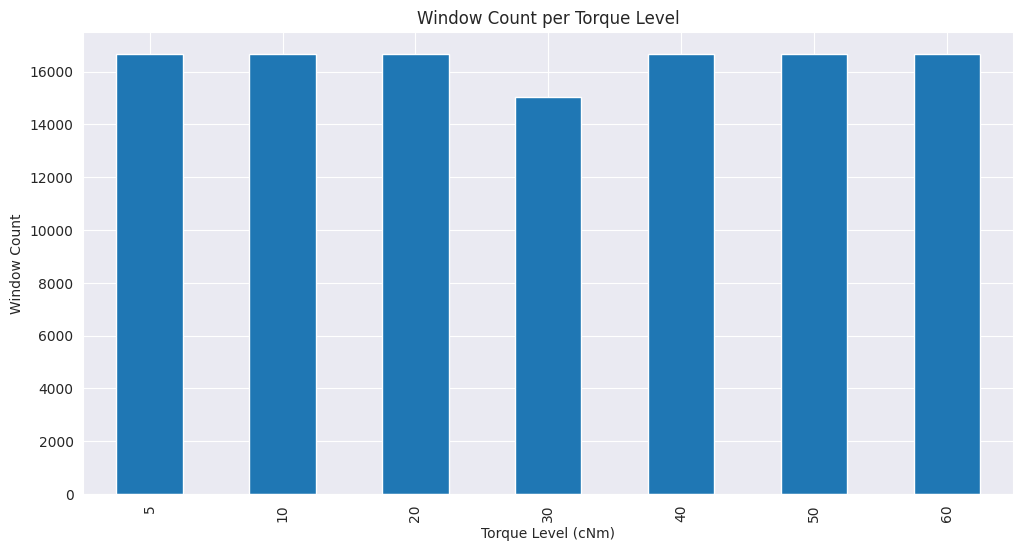

In [ ]:
import pandas as pd
df = pd.read_feather("orion_features_b_sensorA.feather")
print(df.shape)
print(df['label'].value_counts().sort_index())

df['label'].value_counts().sort_index().plot(kind='bar', title='Window Count per Torque Level')
plt.xlabel('Torque Level (cNm)')
plt.ylabel('Window Count')
plt.grid(True)
plt.show()



**Feature Trends Across Torque Levels**

This section analyzes how key features evolve with torque levels by computing the mean feature values per class (cNm). Line plots reveal trends such as increasing or decreasing spectral energy, changes in RMS or kurtosis, and shifts in frequency content — offering insights into how bolt loosening affects the signal characteristics and aiding feature relevance evaluation.



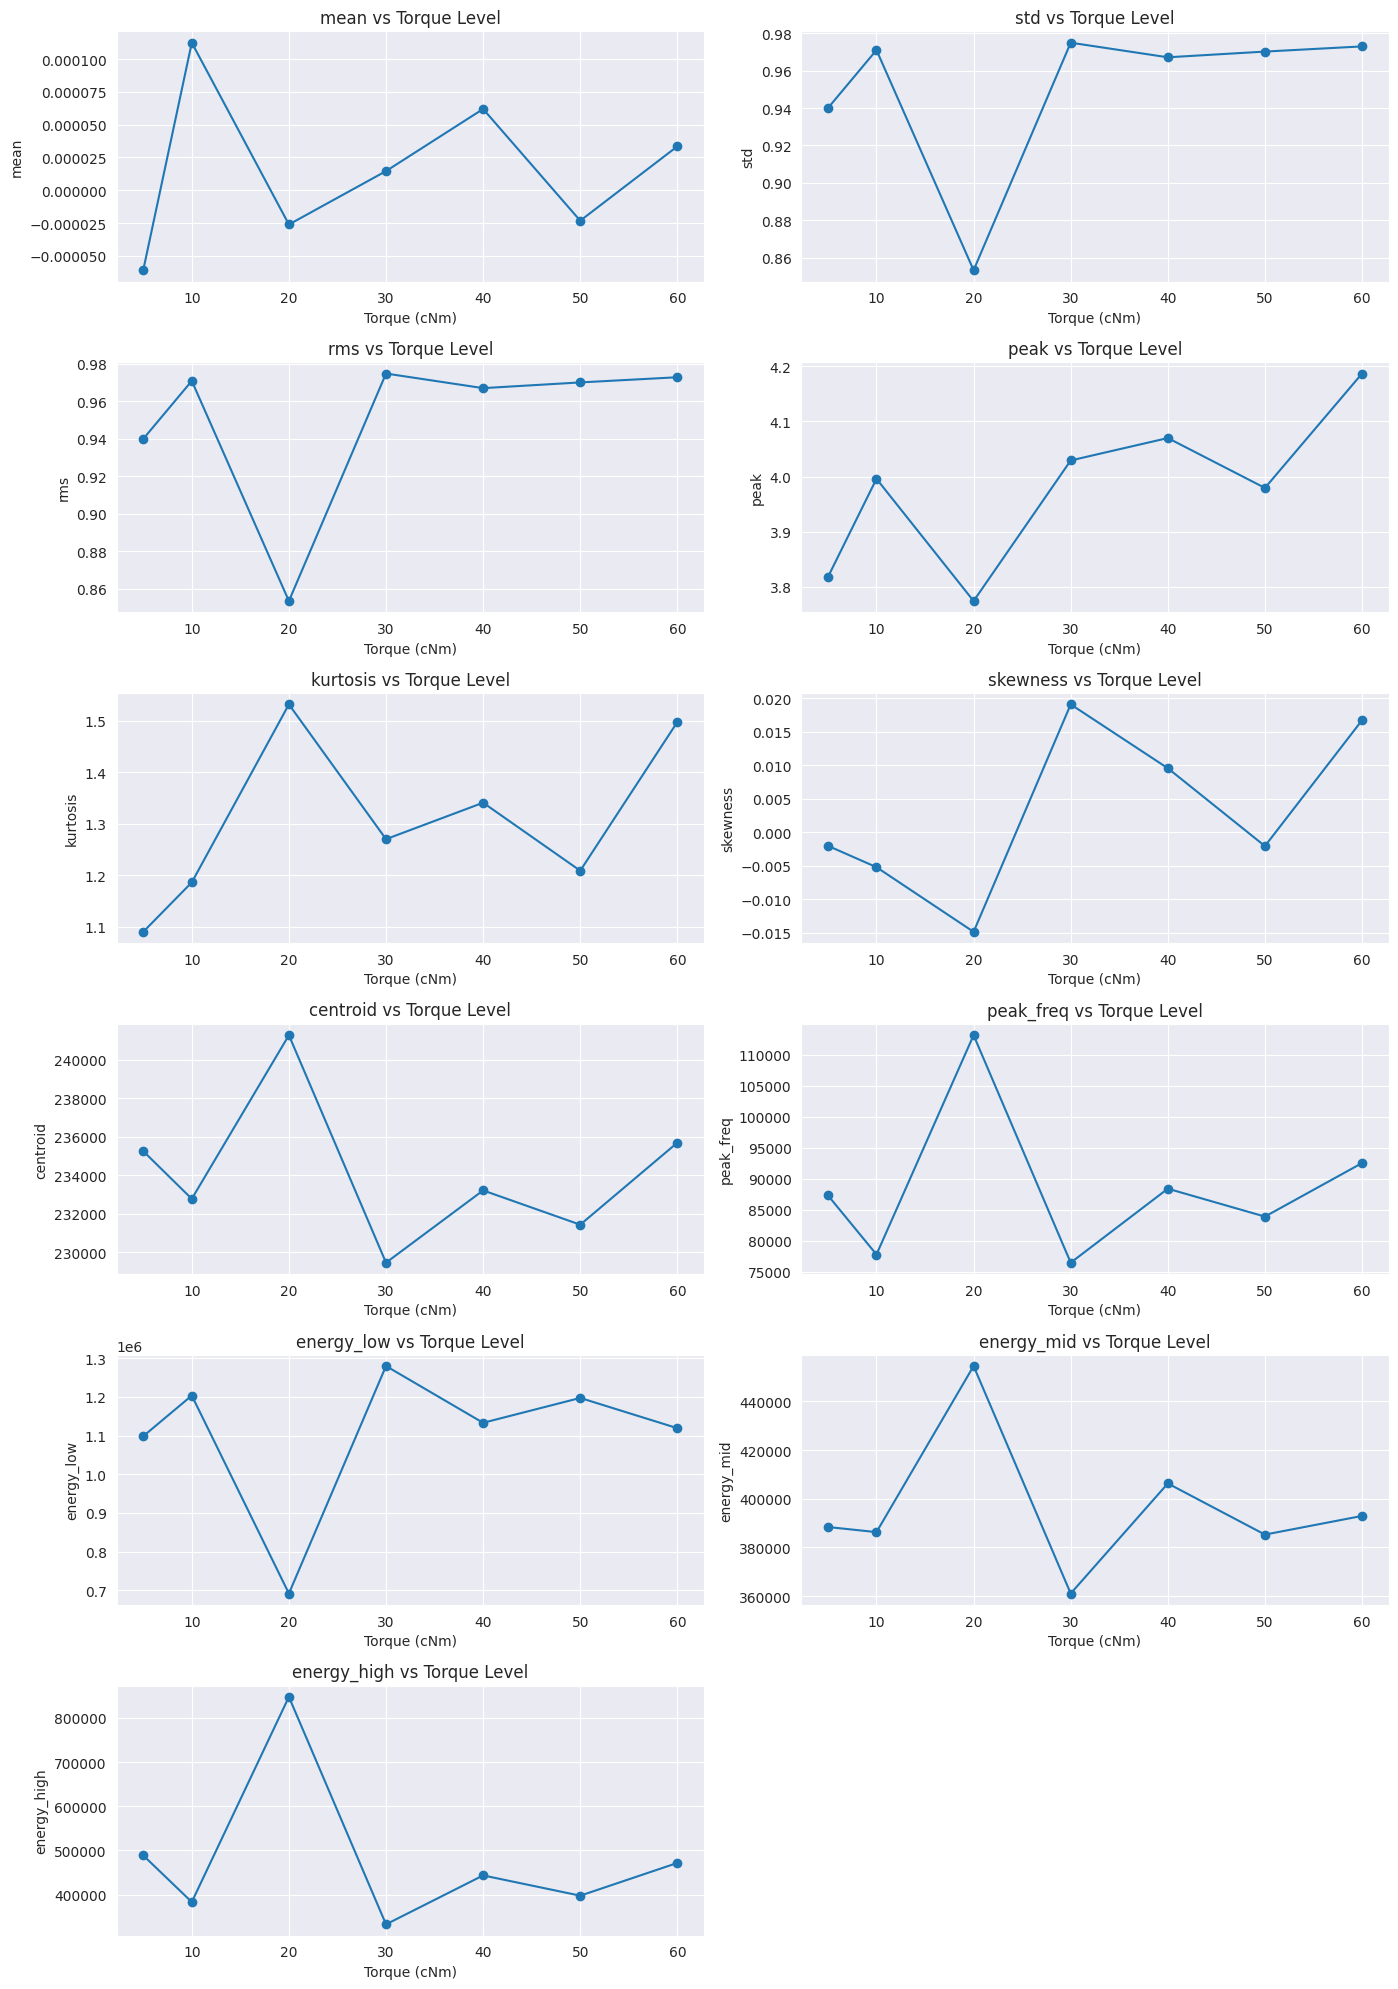

In [ ]:
# Group by label (torque level) and compute mean of each feature
feature_means = df.groupby('label').mean().reset_index()

# Plot selected features vs torque level
selected_features = ['mean', 'std', 'rms', 'peak', 'kurtosis', 'skewness',
                     'centroid', 'peak_freq', 'energy_low', 'energy_mid', 'energy_high']

plt.figure(figsize=(14, 20))
for i, feature in enumerate(selected_features):
    plt.subplot(6, 2, i+1)
    plt.plot(feature_means['label'], feature_means[feature], marker='o')
    plt.title(f"{feature} vs Torque Level")
    plt.xlabel("Torque (cNm)")
    plt.ylabel(feature)
    plt.grid(True)

plt.tight_layout()
plt.show()


# **Supervised Learning - Tightening Level Classification**

This section trains a supervised model to classify bolt tightening levels using the extracted features. The data is standardized and split into training and test sets. Models such as Random Forest, SVM, or XGBoost can be selected. Performance is evaluated using classification reports and confusion matrices, helping assess how well the model distinguishes between different torque conditions.


RANDOM_FOREST Performance:

Training Report:
              precision    recall  f1-score   support

           5       1.00      1.00      1.00      3333
          10       1.00      1.00      1.00      3333
          20       1.00      1.00      1.00      3333
          30       1.00      1.00      1.00      3005
          40       1.00      1.00      1.00      3333
          50       1.00      1.00      1.00      3333
          60       1.00      1.00      1.00      3333

    accuracy                           1.00     23003
   macro avg       1.00      1.00      1.00     23003
weighted avg       1.00      1.00      1.00     23003


Test Report:
              precision    recall  f1-score   support

           5       1.00      1.00      1.00     13333
          10       1.00      1.00      1.00     13333
          20       1.00      1.00      1.00     13331
          30       1.00      1.00      1.00     12022
          40       1.00      1.00      1.00     13330
          50      

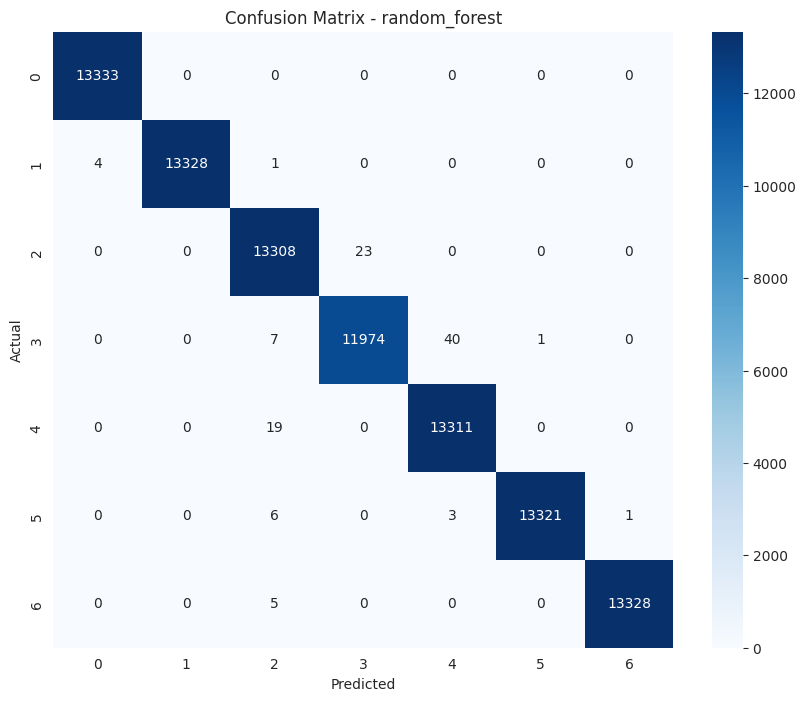

In [ ]:
def train_supervised_model(X_train, y_train, X_test, y_test, model_type='random_forest'):
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize model
    if model_type == 'random_forest':
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_type == 'svm':
        model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
    elif model_type == 'xgboost':
        model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    else:
        raise ValueError("Invalid model_type")

    # Train model
    model.fit(X_train_scaled, y_train)

    # Evaluate
    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)

    print(f"\n{model_type.upper()} Performance:")
    print("\nTraining Report:")
    print(classification_report(y_train, train_pred))

    print("\nTest Report:")
    print(classification_report(y_test, test_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, test_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_type}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return model

df = pd.read_feather("orion_features_b_sensorA.feather")
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42, stratify=y)
model = train_supervised_model(X_train, y_train, X_test, y_test, model_type='random_forest')




# **Feature Importance**

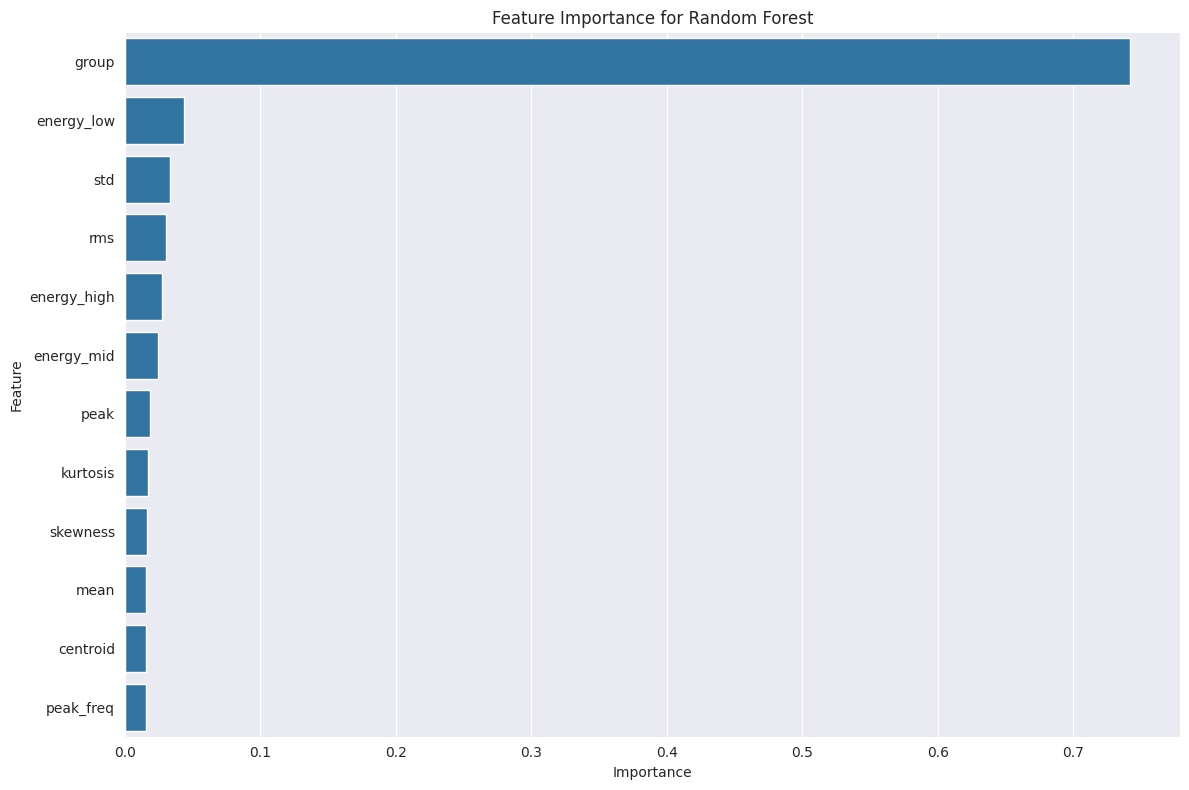

In [ ]:
def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
        plt.title(f'Feature Importance for {model_name}')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Model {model_name} does not have feature importances.")

feature_names = X_train.columns
plot_feature_importance(model, feature_names, "Random Forest")


RANDOM_FOREST Performance:

Training Report:
              precision    recall  f1-score   support

           5       1.00      1.00      1.00      3333
          10       1.00      1.00      1.00      3333
          20       1.00      1.00      1.00      3333
          30       1.00      1.00      1.00      3005
          40       1.00      1.00      1.00      3333
          50       1.00      1.00      1.00      3333
          60       1.00      1.00      1.00      3333

    accuracy                           1.00     23003
   macro avg       1.00      1.00      1.00     23003
weighted avg       1.00      1.00      1.00     23003


Test Report:
              precision    recall  f1-score   support

           5       0.27      0.30      0.29     13333
          10       0.20      0.21      0.21     13333
          20       0.56      0.68      0.62     13331
          30       0.24      0.23      0.24     12022
          40       0.22      0.19      0.20     13330
          50      

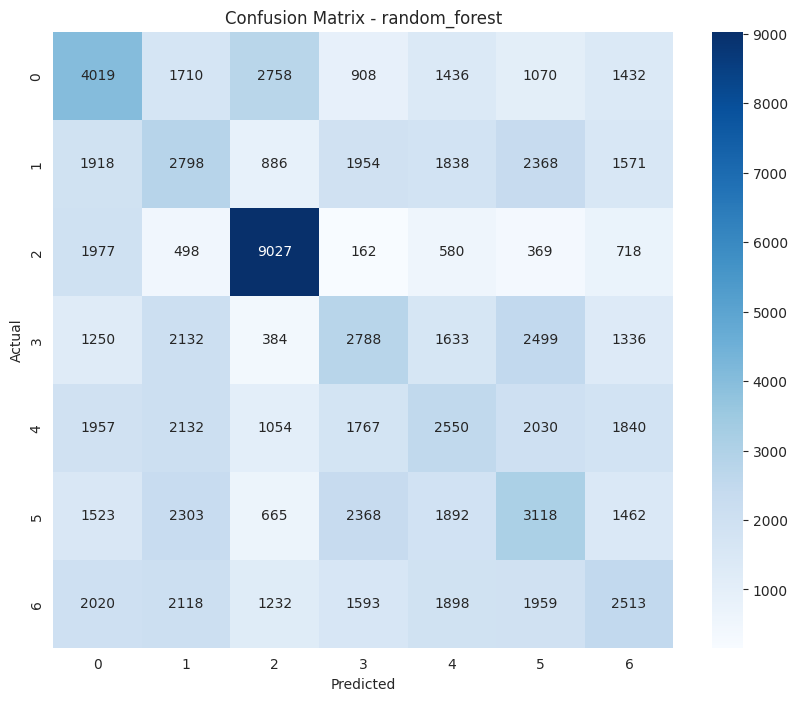

In [ ]:
df = pd.read_feather("orion_features_b_sensorA.feather")

# Corrected approach: Drop both 'label' and 'group' from features
X = df.drop(['label', 'group'], axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42, stratify=y)

# Train the model with the corrected data
def train_supervised_model(X_train, y_train, X_test, y_test, model_type='random_forest'):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)
    print(f"\n{model_type.upper()} Performance:")
    print("\nTraining Report:")
    print(classification_report(y_train, train_pred))
    print("\nTest Report:")
    print(classification_report(y_test, test_pred))
    cm = confusion_matrix(y_test, test_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_type}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return model

model = train_supervised_model(X_train, y_train, X_test, y_test, model_type='random_forest')

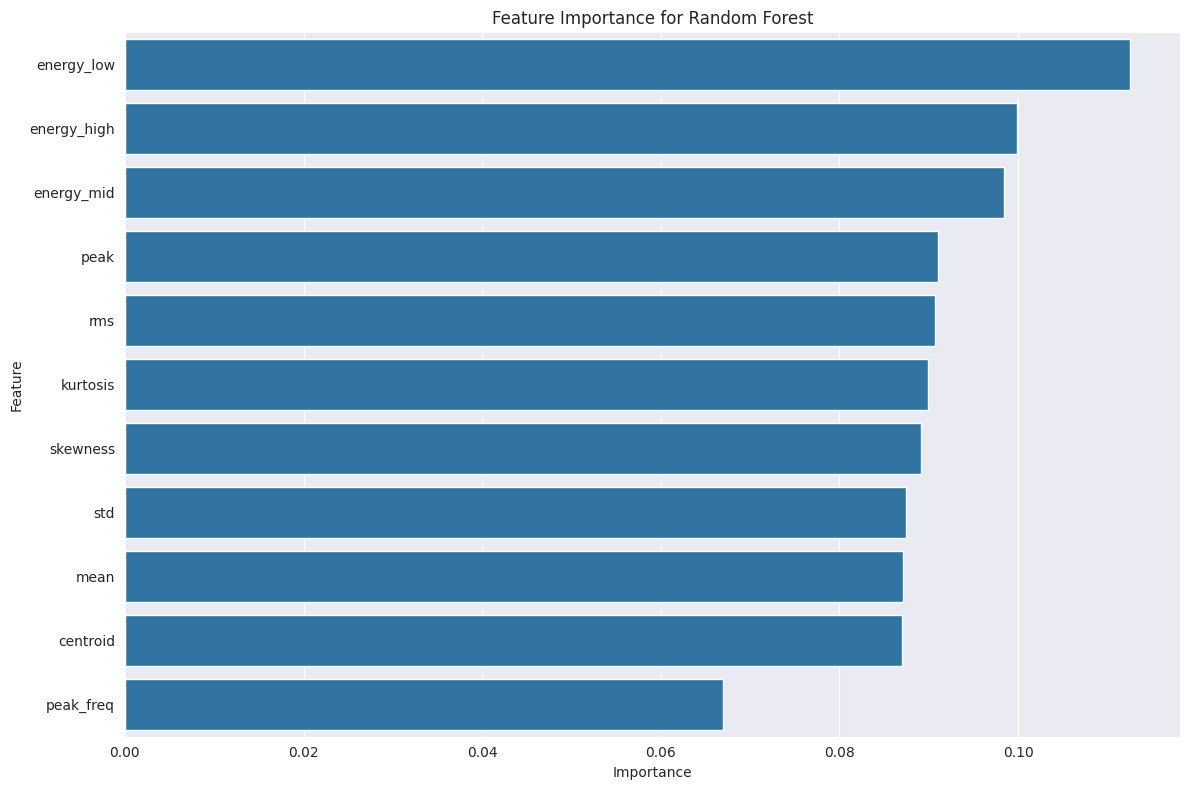

In [ ]:
def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
        plt.title(f'Feature Importance for {model_name}')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Model {model_name} does not have feature importances.")

feature_names = X_train.columns
plot_feature_importance(model, feature_names, "Random Forest")